# Credential free provisioning with Terraform Cloud Agent on AWS ECS

## Overview

This guide provides an example of running [tfc-agent](https://hub.docker.com/r/hashicorp/tfc-agent) on AWS ECS, and shows how you can leverage `tfc-agent` to perform credential free provisioning using [Assume Role](https://registry.terraform.io/providers/hashicorp/aws/latest/docs#assume-role). Though this simple example shows usage within a single AWS account, this pattern is used to allow provisioning across accounts without requiring AWS credentials in Terraform workspaces.

## Setup

The `producer` workspace contains an example of registering and running the tfc-agent on ECS Fargate, along with necessary IAM policies and roles. It creates a `terraform_dev_role` to be using by the consumer who is provisioning infrastructure with Terraform.

The `consumer` workspace provides an example of assuming that role and provisioning an instance without placing credentials in the Terraform Cloud workspace.

Here's what we are going to cover:

1. Create TF Agent Pool and Token.
    * Consumer resources will be deployed via these agents.
1. Configure and provision the `producer` resources/workspace.
    * Create ECS, IAM Role for Consumer, and autoscaling via Lambda.
1. Create TF Workspace for Consumer.
    * Receives configuration and sends to TF Agent.
1. Configure and provision the `consumer` workspace.
    * Uses the `terraform_dev_role` created in step 1.
    * Assume role and deploy resource.

## Prerequisites

* [Terraform Cloud Business Tier](https://www.hashicorp.com/blog/announcing-hashicorp-terraform-cloud-business)
* [Terraform Cloud Token](https://learn.hashicorp.com/tutorials/terraform/cloud-login)
* AWS Credentials
* AWS CLI

### Set Main Environment Variables

In [ ]:
export RED="\e[0;31m" YELLOW="\e[0;33m" BLDYELLOW="\e[1;33m" GREEN="\e[0;32m"
export CYAN="\e[0;36m" BLUE="\e[0;34m" WHITE="\e[0;37m" BLDWHITE="\e[1;37m"
export NC="\e[0m"
# Prevent commands starting with a space to be saved to shell history.
HISTCONTROL=ignoreboth # do not save lines that begin with space in history

printf "${GREEN}# Set MAIN_DIR for future reference.${NC}\n"
export MAIN_DIR=${PWD}

Be sure to replace `PREFIX`, `TF_ORG`, and `TF_WS_NAME` with your own values.

In [ ]:
export PREFIX=pphan
export TF_ORG=pphan
export TFC_ORG=$TF_ORG
export TF_WS_NAME=consumer
export TOKEN=$(jq -r '.credentials."app.terraform.io".token' ~/.terraform.d/credentials.tfrc.json); export TFE_TOKEN=$TOKEN

export TF_GIT_DIR="config/tfc-agent"
export TFE_PROVIDER_DIR="tfe-provider"
printf "${GREEN}# Set Terraform Variables.${NC}\n"
printf "\n$MAIN_DIR \n $TF_GIT_DIR \n TFE_PROVIDER_DIR: $TFE_PROVIDER_DIR
 TOKEN: $TOKEN \n TF_ORG: $TFC_ORG
 TF_WS_NAME: $TF_WS_NAME"

### AWS Credentials

**SE TIP:** You can get AWS creds from the following Instruqt tracks [AWS Dynamic Secrets](https://play.instruqt.com/hashicorp/tracks/vault-aws-dynamic-secrets) or [AWS Open Lab](https://play.instruqt.com/hashicorp/tracks/aws-open-lab).

You can grab the grabs from a terminal tab or console tab.

```shell
env | grep -i ^aws_ | grep -v ACCOUNT
```

> NOTE: The labs and creds are good for 20 or 480 minutes respectively.

Unset any previous AWS credentials in environment variables.

In [ ]:
unset AWS_SESSION_TOKEN AWS_SECRET_ACCESS_KEY AWS_ACCESS_KEY_ID
envo | grep AWS || env | grep AWS

Set the AWS credentials

In [ ]:
export AWS_ACCESS_KEY_ID=REPLACE_ME
export AWS_SECRET_ACCESS_KEY=REPLACE_ME
export AWS_REGION=us-west-2

Confirm the credentials are in place.

In [ ]:
env | grep AWS

### Clone the tfc-agent repo

In [ ]:
mkdir -p $TF_GIT_DIR
# cd config
git clone https://github.com/assareh/tfc-agent.git $TF_GIT_DIR

## Steps

## Terraform Cloud Agent Token
An agent token is a secret value that is used to uniquely identify your agents and allow them to register themselves with your Terraform Cloud organization. Please refer to the [documentation](https://www.terraform.io/docs/cloud/agents/index.html#managing-agent-pools) for an explanation of what an agent pool is and how to create an agent token in the Terraform Cloud Settings console.

Additionally, these may now be created and managed with Terraform due to the addition of the following resources and data sources in version 0.24.0 of the [tfe provider](https://registry.terraform.io/providers/hashicorp/tfe/latest):
* [`tfe_agent_pool`](https://registry.terraform.io/providers/hashicorp/tfe/latest/docs/resources/agent_pool) resource
* [`tfe_agent_pool`](https://registry.terraform.io/providers/hashicorp/tfe/latest/docs/data-sources/agent_pool) data source
* [`tfe_agent_token`](https://registry.terraform.io/providers/hashicorp/tfe/latest/docs/resources/agent_token) resource

In [ ]:
pushd ${TF_GIT_DIR}/tfc-agent-ecs/producer

### Create Agent Pool

In [ ]:
mkdir -p ${MAIN_DIR}/${TF_GIT_DIR}/tfc-agent-ecs/agent && cd $_

In [ ]:
cat > agent_pool.tf <<EOF
resource "tfe_agent_pool" "test-agent-pool" {
  name         = var.agent_pool_name
  organization = var.organization
}
resource "tfe_agent_token" "test-agent-token" {
  agent_pool_id = tfe_agent_pool.test-agent-pool.id
  description   = var.agent_token_description
}

variable "agent_pool_name" {}
variable "agent_token_description" {}
variable "organization" {}

output "agent_pool_id" { value = tfe_agent_pool.test-agent-pool.id }
output "agent_token_token" {
  value = tfe_agent_token.test-agent-token.token
  sensitive = true
}
EOF

Customize your agents by modifying the values for the variables.

In [ ]:
tee terraform.auto.tfvars <<EOF
agent_pool_name         = "beeker-agent-pool" # "my-agent-pool-name"
agent_token_description = "beeker-agents" # "my-agent-token-name"
organization            = "${TFC_ORG}"
EOF

### Provision Agent Resources

In [ ]:
terraform init

In [ ]:
terraform validate && tf apply -input=false -auto-approve

Get agent pool with API

In [ ]:
AGENT_POOL_ID=$(curl --silent \
  --header "Authorization: Bearer $TOKEN" \
  --header "Content-Type: application/vnd.api+json" \
  --request GET \
  https://app.terraform.io/api/v2/organizations/$TFC_ORG/agent-pools | jq -r '.data[0].id')
printf "$AGENT_POOL_ID\n"

---
## TFC Agent in Amazon ECS Producer Workspace

This workspace will require AWS access/credentials to provision.

It will be used to provision the following items:

* ECS
* Lambda Function for autoscaling
* IAM role

### Autoscaling tfc-agent with a Lambda Function

There is an included Lambda function that, when combined with [Terraform Cloud notifications](https://www.terraform.io/docs/cloud/workspaces/notifications.html), enables autoscaling the number of Terraform Cloud Agents running.

To use it, you'll need to:
1. Configure the `desired_count` and `max_count` Terraform variables.
    * `desired_count` sets the baseline number of agents to always be running.
    * `max_count` sets the maximum number of agents allowed to be running at one time.
2. Configure a [generic notification](https://www.terraform.io/docs/cloud/workspaces/notifications.html#creating-a-notification-configuration) for each Terraform Cloud workspace that will be using an agent for its [execution mode](https://www.terraform.io/docs/cloud/workspaces/settings.html#execution-mode)
    * We will use the [Terraform Enterprise provider](https://registry.terraform.io/providers/hashicorp/tfe/latest/docs) to configure this in consumer workspace.

Expected Results:

* When a run is queued, TFC will send a notification to the Lambda function
    * This will increase the number of running agents by 1.
* When the run is completed, TFC will send another notification to the Lambda function.
    * This will decrease the number of running agents by 1.

NOTE: [Speculative Plans](https://www.terraform.io/docs/cloud/run/index.html#speculative-plans) will not trigger this autoscaling.

### Set Variables
Please provide values for the following required [variables](https://www.terraform.io/docs/language/values/variables.html#assigning-values-to-root-module-variables):
* `prefix`: a name prefix to add to the resources
* `tfc_agent_token`: The Terraform Cloud agent token you would like to use. NOTE: This is a secret and should be marked as sensitive in Terraform Cloud. (See the next section for how to create this.)

In [ ]:
mkdir -p $MAIN_DIR/$TF_GIT_DIR/tfc-agent-ecs/producer && cd $_ ; pwd

Set `TFC_AGENT_TOKEN` from terraform output of agent provisioning.

In [ ]:
TFC_AGENT_TOKEN=$(terraform -chdir=../agent output agent_token_token)

In [ ]:
cat > outputs_2.tf << EOF
output "notification_token" {
  value = aws_ssm_parameter.notification_token.value
  sensitive = true
}
EOF

In [ ]:
tee terraform.auto.tfvars <<EOF
desired_count = 2
max_count     = 4
notification_token = "SuperSecret!!"
prefix        = "${PREFIX}"
region        = "${AWS_REGION}"
tfc_agent_token = ${TFC_AGENT_TOKEN} #$(echo $AGENT_TOKEN | jq .attributes.token)
task_cpu = 1024 # 1024: 1cpu, 2048: 2cpu
task_mem = 8192
task_def_mem = 2048 # 2048, 4096
EOF

We recommend you review all other variables and configure their values according to your specifications. You can adjust the resource allocations for the agent task with `task_cpu`, `task_mem`, `task_def_cpu`, and `task_def_mem`. (Refer to the [AWS docs](https://docs.aws.amazon.com/AmazonECS/latest/developerguide/task_definition_parameters.html#task_size) for the supported sizes.) As of this writing, the terraform run environment built in to Terraform Cloud provides 2 cores and 2GB of RAM. However, I have used the agent with as little as 256MB of RAM. YMMV

`ttl` and `common_tags` are used only for tagging and are completely optional.

### Provision Producer Resources

In [ ]:
terraform init

In [ ]:
terraform validate && terraform plan -input=false -out=tfplan

In [ ]:
terraform apply -input=false -auto-approve

Confirm that agents are registering with TFC.

In [ ]:
open https://app.terraform.io/app/${TFC_ORG}/settings/agents

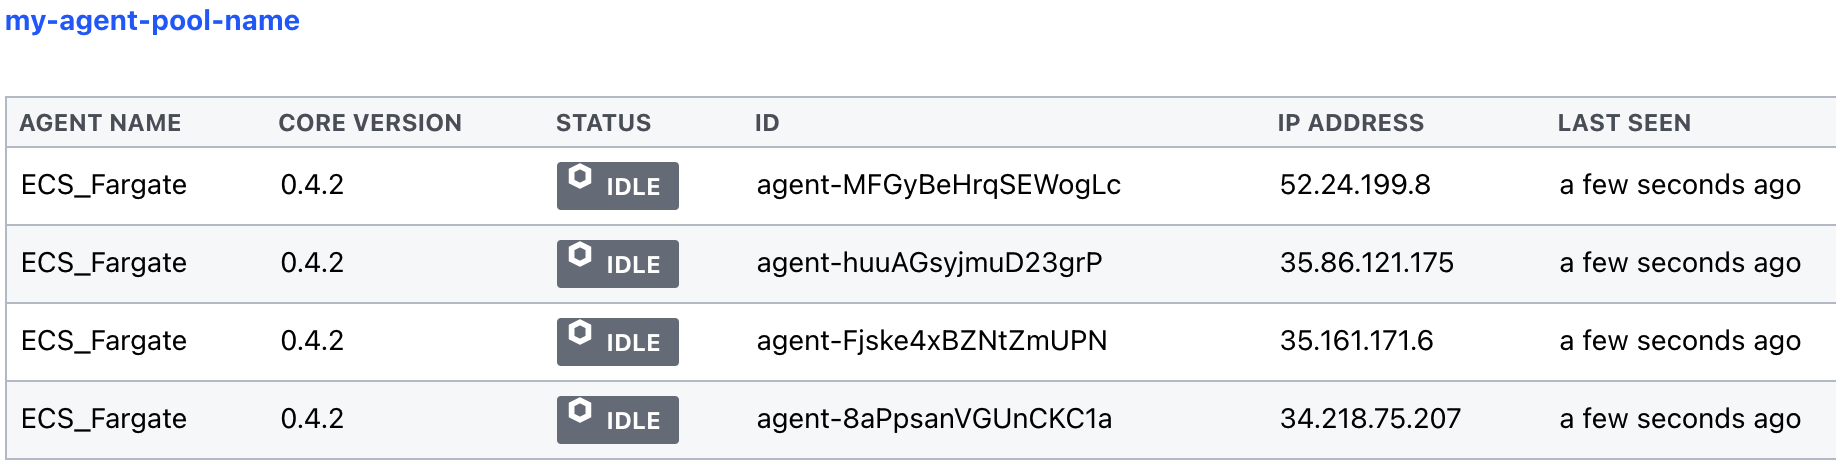

Or from the API.

In [ ]:
curl \
  --header "Authorization: Bearer $TOKEN" \
  --header "Content-Type: application/vnd.api+json" \
  --request GET \
  https://app.terraform.io/api/v2/agent-pools/$(terraform -chdir=../agent output -raw  agent_pool_id)/agents | jq -c .data[]

In both the UI and the API, you should see four agents.

### References
* [Terraform Cloud Agents](https://www.terraform.io/docs/cloud/workspaces/agent.html)
* [Agent Pools and Agents API](https://www.terraform.io/docs/cloud/api/agents.html)
* [Agent Tokens API](https://www.terraform.io/docs/cloud/api/agent-tokens.html)

## Create and Configure a Workspace with TFE Provider

Create a workspace with the [TFE provider](https://registry.terraform.io/providers/hashicorp/tfe/latest/docs). The following steps will setup the following items via the TFE Provider:

* `execution_mode`
* `agent_pool`
* `terraform_version`
* `auto_apply`
* `queue_all_runs`

In [ ]:
# Confirm variables are set.
printf "\nMAIN_DIR: $MAIN_DIR \n PROVIDER_DIR: $TFE_PROVIDER_DIR \n TF_ORG: $TF_ORG \n TF_WS_NAME: $TF_WS_NAME \n"

Create and go to folder for your TFC Workspace configuration.

In [ ]:
mkdir -p $MAIN_DIR/$TF_GIT_DIR/tfc-agent-ecs/$TFE_PROVIDER_DIR && cd $_ ; pwd

Define the required providers and versions.

In [ ]:
cat > versions.tf <<-EOF
terraform {
  required_providers {
    tfe = {
      source  = "hashicorp/tfe"
      version = ">=0.26.1"
    }
  }
  required_version = "> 0.14" # tf oss version
}
EOF

In [ ]:
cat > workspace-consumer.tf <<-"EOF"
resource "tfe_workspace" "this" {
  name         = "${var.tfc_workspace_name}"
  organization = var.tfc_org
  queue_all_runs = false
  execution_mode = var.execution_mode
  agent_pool_id  = var.agent_pool_id
  auto_apply     = var.auto_apply
  terraform_version = var.terraform_version
  tag_names = ["boss:eljefe", "owner:pphan"] # New in Terraform Cloud
}

resource "tfe_notification_configuration" "agent_lambda_webhook" {
  name             = "tfc-agent"
  enabled          = true
  destination_type = "generic"
  token            = var.notification_token
  triggers         = ["run:created", "run:completed", "run:errored"]
  url              = var.webhook_url
  workspace_id     = tfe_workspace.this.id
}
EOF

In [ ]:
cat > variables.tf <<-"EOF"
#// TFC Variables and Outputs
variable "agent_pool_id" {
  description = "auto apply changes when a Terraform plan is successful"
  default     = false
}
variable "auto_apply" {
  description = "auto apply changes when a Terraform plan is successful"
  default     = false
}
variable "execution_mode" {
  description = "execution mode to use - remote, local, agent"
  default     = "local"
}
variable "notification_token" {
  description = "Token to authenticate with Lambda"
}
variable "region" {
  description = "AWS Region"
}
variable "tfc_org" {
  description = "The Terraform Cloud organization to create things in"
  default     = "REPLACE_ME"
}
variable "tfc_workspace_name" {
  description = "Terraform workspace name"
  default     = "consumer"
}
variable "terraform_version" {
  description = "Version of Terraform to use for this workspace."
  default     = null
}
variable "webhook_url" {
  description = "URL target for workspace notification"
}

output "workspace_id" {
    value = tfe_workspace.this.id
}
EOF

### Add Notification to Workspaces

Here's how we add notifications to a workspace with the [TFE provider](https://registry.terraform.io/providers/hashicorp/tfe/latest/docs):

```go
resource "tfe_notification_configuration" "agent_lambda_webhook" {
  name             = "tfc-agent"
  enabled          = true
  destination_type = "generic"
  token            = var.notification_token
  triggers         = ["run:created", "run:completed", "run:errored"]
  url              = var.webhook_url
  // url              = data.terraform_remote_state.tfc-agent-ecs-producer.outputs.webhook_url
  workspace_id     = tfe_workspace.this.id
}
```

* `token` - the notification token
* `triggers` - type of events that will trigger a notification
* `url` - webhook url

### Set variables for TFC Workspace

In [ ]:
tee terraform.tfvars <<-EOF
agent_pool_id      = "$(terraform -chdir=../agent output -raw  agent_pool_id)"
auto_apply         = true
execution_mode     = "agent"
notification_token = "$(terraform -chdir=../producer output -raw  notification_token)"
region             = "$AWS_REGION"
tfc_workspace_name = "${TF_WS_NAME}"
tfc_org            = "${TF_ORG}"
terraform_version  = "$(terraform version -json | jq -r .terraform_version)"
webhook_url        = "$(terraform -chdir=../producer output -raw  webhook_url)"
EOF

* `execution_mode` - Set to agent
* `agent_pool_id` - Specify which agent pool to use
* `notification_token` - we reference this from the `producer` workspace
* `webhook_url` - we reference this from the `producer` workspace

### Provision Consumer TFC Workspace

In [ ]:
tf init -upgrade

In [ ]:
terraform validate && terraform plan -input=false

In [ ]:
terraform apply -input=false -auto-approve

### Verification

In [ ]:
curl -s \
  --header "Authorization: Bearer $TOKEN" \
  --header "Content-Type: application/vnd.api+json" \
  https://app.terraform.io/api/v2/organizations/${TFC_ORG}/workspaces/consumer \
  | jq .data | grep -E "\"name\"|mode"

Verify that your workspace is configured correctly.

In [ ]:
open https://app.terraform.io/app/${TFC_ORG}/workspaces/consumer/settings/notifications

<img src=https://raw.githubusercontent.com/assareh/tfc-agent/master/tfc-agent-ecs/producer/files/notification_config.png width=640>

---

## TFC Agent in Amazon ECS Consumer Workspace

No AWS credentials are required in this workspace. AWS access is obtained through the `tfc-agent`. The `tfc-agent` running in AWS ECS is granted IAM permissions to assume roles. A Terraform user can invoke a role in their aws provider as follows:

```go
provider "aws" {
  assume_role {
    role_arn = ...
  }
...
```

In this model it is important to enforce least privilege on Terraform Cloud workspace access using [Single Sign-on](https://www.terraform.io/docs/cloud/users-teams-organizations/single-sign-on.html) and the built-in [RBAC controls](https://www.terraform.io/docs/cloud/workspaces/access.html).

Create and go to folder for your TFC Workspace configuration.

In [ ]:
mkdir -p $MAIN_DIR/$TF_GIT_DIR/tfc-agent-ecs/consumer && cd $_ ; pwd

### main.tf

This workspace will create an Ubuntu VM.

In [ ]:
# backup original main.tf for reference
mv main.tf main.tf.$(date +%Y%m%d)

In [ ]:
cat > main.tf <<EOF
provider "aws" {
  region = var.region
  assume_role {
    role_arn     = var.dev_role_arn
    session_name = "terraform"
  }
  default_tags {
    tags = local.common_tags
  }
}

data "aws_caller_identity" "current" {}

data "aws_ami" "ubuntu-vault-oss" {
  owners      = ["099720109477"] # Canonical
  # owners      = ["679593333241"] # HashiCorp
  most_recent = true
  filter {
    name   = "name"
    values = ["ubuntu/images/hvm-ssd/ubuntu-focal-20*-amd64-server-*"]
    # values = ["hashicorp/marketplace/vault-1.5.0-*"]
  }
  filter {
    name   = "virtualization-type"
    values = ["hvm"]
  }
}

resource "aws_instance" "vault" {
  ami           = data.aws_ami.ubuntu-vault-oss.id
  instance_type = "t3.small"
}

resource "null_resource" "delay" {
  provisioner "local-exec" {
    command = "sleep 60"
  }
}

output "caller_user" {
  value = data.aws_caller_identity.current.user_id
}
EOF

* `aws_caller_identity` Use this data source to get the access to the effective Account ID, User ID, and ARN in which Terraform is authorized.

### Set Variables

Provide a value for the following required [variable](https://www.terraform.io/docs/language/values/variables.html#assigning-values-to-root-module-variables):

* `dev_role_arn`: The Amazon Resource Name of the dev role to be assumed.
    * This is the value of output `terraform_dev_role` from the Producer workspace.

In [ ]:
tee terraform.auto.tfvars <<EOF
dev_role_arn=$(terraform -chdir=../producer output terraform_dev_role)
region      ="${AWS_REGION}"
EOF

### Define Remote backend

Specify the TFC org and workspace that will run this plan/apply and store the state files.

In [ ]:
tee remote_backend.tf <<EOF
terraform {
  backend "remote" {
    hostname     = "app.terraform.io"
    organization = "${TFC_ORG}"
    workspaces {
      name = "consumer"
    }
  }
}
EOF

### Provision Consumer Resources

TIP: If you are using AWS credentials from Instruqt, the environment will not have a default VPC.

Create a default VPC if you don't have one.

In [ ]:
# Create a default VPC with subnets
aws ec2 create-default-vpc

In [ ]:
aws ec2 describe-vpcs | jq -c

In [ ]:
mkdir -p $MAIN_DIR/$TF_GIT_DIR/tfc-agent-ecs/consumer && cd $_ ; pwd

In [ ]:
terraform init

In [ ]:
terraform validate && terraform apply -input=false -auto-approve -h

In [ ]:
terraform apply -replace="aws_instance.vault" -replace="null_resource.delay" -input=false -auto-approve 

In the outputs, we display the ARN that we use to create the resource. Notice that it uses the `*-terraform_dev_role` role.

For the consumer workspace, we did not provide AWS credentials.

### Verfication

On this page, you should see one "`IDLE`" and one "`BUSY`" agent.
`EXITED`

https://app.terraform.io/app/${TFC_ORG}/settings/agents

If you monitor the ECS Clusters console, you will see two tasks and possibly a third if your timing is good. While the consumber workspace is running, a new tfc-agent comes up. When its done, a tfc-agent is removed.

In [ ]:
open https://${AWS_REGION}.console.aws.amazon.com/ecs/home?region=${AWS_REGION}#/clusters/${PREFIX}-cluster/tasks

### Troubleshooting

* Do you have a Terraform Cloud workspace?
    * Make sure you created a TFC Workspace for "consumer"
* Are your TFC workspace settings correct?
    * Ensure the consumer workspace [Execution Mode](https://www.terraform.io/docs/cloud/workspaces/settings.html#execution-mode) is set to `Agent`!
    * Make sure you have a remote backend configuration pointing to your workspace.
    * We defined this inside of `remote_backend.tf` file.

* Lambda

In [ ]:
open https://${AWS_REGION}.console.aws.amazon.com/lambda/home?region=${AWS_REGION}#/functions

* Cloudwatch

In [ ]:
open https://${AWS_REGION}.console.aws.amazon.com/cloudwatch/home?region=${AWS_REGION}#logsV2:log-groups

## Clean Up

### Destroy Resources

Make sure you are in the correct folder.

In [ ]:
cd $MAIN_DIR/$TF_GIT_DIR/tfc-agent-ecs

Delete consumer resources.

In [ ]:
terraform -chdir=consumer destroy -auto-approve

Delete consumer TFC workspace

In [ ]:
terraform -chdir=tfe-provider destroy -auto-approve

Delete producer resources.

In [ ]:
terraform -chdir=producer destroy -auto-approve

Delete agent token and pool

In [ ]:
terraform -chdir=agent destroy -auto-approve

Delete file artifacts

In [ ]:
cd $MAIN_DIR
printf "Are you sure you want to do this?\n"
echo rm -rf $TF_GIT_DIR

In [ ]:
rm -rf $TF_GIT_DIR

Unset sensitive variables

In [ ]:
unset AWS_ACCESS_KEY_ID AWS_SECRET_ACCESS_KEY

## Additional Topics

* A [Sentinel](https://www.terraform.io/docs/cloud/sentinel/index.html) policy like [this example](https://github.com/hashicorp/terraform-guides/blob/master/governance/third-generation/aws/restrict-assumed-roles-by-workspace.sentinel) can be used to restrict which roles would be allowed in a given workspace.
* Declaring AssumeRole in the provider block is not necessarily required. IAM permissions given to the agent role directly will be available to Terraform runs without any provider configuration necessary.
* The agent image and environment can be customized. For example, abstracting the role ARNs from the Terraform consumers entirely is possible if you were to embed an AWS CLI config file into the agent image. In this scenario users can select an AWS role or profile with `profile = "dev"` in their provider block.

## References

* Documentation
    * [Terraform Cloud Agent Docs](https://www.terraform.io/docs/cloud/workspaces/agent.html)
    * [Agent Pools and Agents API](https://www.terraform.io/docs/cloud/api/agents.html)
    * [Agent Tokens API](https://www.terraform.io/docs/cloud/api/agent-tokens.html)
    * [AWS Provider Authentication Docs](https://registry.terraform.io/providers/hashicorp/aws/latest/docs#codebuild-ecs-and-eks-roles)
* Provisioning
    * [Andy's TFC Agent Repo](https://github.com/assareh/tfc-agent) - Lots of examples for deployin TFC Agents
    * [terraform-cloud-agent on Kubernetes module by Phil Sautter](https://registry.terraform.io/modules/redeux/terraform-cloud-agent/kubernetes/latest)
    * [tfc-cloud-agent on Kubernetes module by Cloud Posse](https://registry.terraform.io/modules/cloudposse/tfc-cloud-agent/kubernetes/latest)
    * [tfc_agent Chef cookbook](https://supermarket.chef.io/cookbooks/tfc_agent)
* [hashicorp/tfc-agent on DockerHub](https://hub.docker.com/r/hashicorp/tfc-agent)
